In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import statsmodels.api as sm
from scipy.special import gamma, loggamma, factorial
import scipy.stats
from scipy.interpolate import interp1d
from matplotlib.ticker import AutoMinorLocator 
from matplotlib import rc, font_manager
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors
from mycolorpy import colorlist as mcp
from matplotlib import legend_handler
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import collections
import matplotlib
import shapely.geometry
import shapely.ops 
from geopy.geocoders import Nominatim
import geopandas as gpd
import mapclassify
import jenkspy
import contextily as cx
import os
import rioxarray as rx
import pyreadr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import plots
import seaborn as sns

In [2]:
wd = os.path.dirname(os.getcwd())

In [3]:
# # Only uncomment if you want to reread the rdi raster and generate a gpkg with point geometries
# # Import rdi raster and turn it into geodataframe of points based on centroids of pixels

file_raster = wd + '/data/inputs/rdi/povmap-grdi-v1-geotiff/povmap-grdi-v1.tif'
rds = rx.open_rasterio(file_raster)
rds.name = "rdi"
df_rdi = rds.squeeze().to_dataframe().reset_index()

df_rdi = df_rdi[df_rdi['rdi']>=0].reset_index(drop=True)

geometry = gpd.points_from_xy(df_rdi.x, df_rdi.y)
gdf_rdi = gpd.GeoDataFrame(df_rdi, crs=rds.rio.crs, geometry=geometry)
gdf_rdi = gdf_rdi.drop(['y', 'x', 'band', 'spatial_ref'], axis = 1)


RasterioIOError: /Users/carmen/Library/CloudStorage/OneDrive-TheUniversityofLiverpool/GitHub/latin-mobility-covid/data/inputs/rdi/povmap-grdi-v1-geotiff/povmap-grdi-v1.tif: No such file or directory

In [108]:

country = 'MEX'

if country == 'ARG':
    country_full = 'argentina'
    level = '2'
elif country == 'CHL':
    country_full = 'chile'
    level = '3'
elif country == 'COL':
    country_full = 'colombia'
    level = '2'
elif country == 'MEX':
    country_full = 'mexico'
    level = '2'
elif country == 'PER':
    country_full = 'peru'
    level = '3'

# Spatial joins: FUAs & admin areas with RDI & population Worldpop

### FUAs

In [109]:

file_raster = wd + '/data/inputs/population/' + country.lower() + '_ppp_2020_1km_Aggregated.tif'
rds = rx.open_rasterio(file_raster)
rds.name = "population"
df_pop = rds.squeeze().to_dataframe().reset_index()

df_pop = df_pop[df_pop['population']>=0].reset_index(drop=True)

geometry = gpd.points_from_xy(df_pop.x, df_pop.y)
gdf_pop = gpd.GeoDataFrame(df_pop, crs=rds.rio.crs, geometry=geometry)
gdf_pop = gdf_pop.drop(['y', 'x', 'band', 'spatial_ref'], axis = 1)

In [110]:
gdf_fua = gpd.read_file(wd + '/data/inputs/boundaries/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0/GHS_FUA_UCDB2015_GLOBE_R2019A_54009_1K_V1_0.gpkg').to_crs('EPSG:4326')


In [111]:
 
gdf_fua_join = gdf_fua[gdf_fua['Cntry_ISO'] == country].reset_index(drop=True)
gdf_rdi_join = gdf_rdi
gdf_fua_rdi = gdf_fua_join.sjoin(gdf_rdi_join, how="left", predicate='intersects')
gdf_fua_rdi['index'] = gdf_fua_rdi.index
gdf_group = gdf_fua_rdi.groupby(['index']).mean('').reset_index(drop=True)
gdf_fua_join['rdi'] = gdf_group['rdi']
gdf_fua_rdi = gdf_fua_join


gdf_fua_rdi_join = gdf_fua_rdi
gdf_pop_join = gdf_pop
gdf_fua_rdi_pop = gdf_fua_rdi_join.sjoin(gdf_pop_join, how="left", predicate='intersects')
gdf_fua_rdi_pop['index'] = gdf_fua_rdi_pop.index
gdf_group = gdf_fua_rdi_pop.groupby(['index']).sum().reset_index(drop=True)
gdf_fua_rdi_join['pop2020'] = gdf_group['population']
gdf_fua_rdi_pop = gdf_fua_rdi_join

gdf_fua_rdi = gdf_fua_rdi_pop

gdf_fua_rdi = gdf_fua_rdi.to_crs('epsg:3857')
gdf_fua_rdi['den2020'] = gdf_fua_rdi['pop2020']/(gdf_fua_rdi['geometry'].area*10**-6)
gdf_fua_rdi = gdf_fua_rdi.to_crs('epsg:4326')

gdf_fua_rdi.to_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_fua_rdi.gpkg')

/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_6263/2965886767.py:5: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  gdf_group = gdf_fua_rdi.groupby(['index']).mean('').reset_index(drop=True)
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_6263/2965886767.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gdf_group = gdf_fua_rdi_pop.groupby(['index']).sum().reset_index(drop=True)


### Admin areas

In [112]:
gdf_admin = gpd.read_file(wd + '/data/inputs/boundaries/gadm41_' + country + '_' + level + '.json')


In [113]:
gdf_fua_join = gdf_fua[gdf_fua['Cntry_ISO'] == country].reset_index(drop=True)
gdf_fua_join['pop2020_FUA'] = gdf_fua_rdi['pop2020']
gdf_fua_join['den2020_FUA'] = gdf_fua_rdi['den2020']
gdf_admin_fua = gdf_admin.sjoin(gdf_fua_join, how="left", predicate="intersects")
gdf_admin_fua = gdf_admin_fua.drop(['index_right'], axis=1)
gdf_rdi_join = gdf_rdi
gdf_admin_fua_rdi = gdf_admin_fua.sjoin(gdf_rdi_join, how="left", predicate='intersects')
gdf_admin_fua_rdi['index'] = gdf_admin_fua_rdi.index
gdf_group = gdf_admin_fua_rdi.groupby(['index']).mean().reset_index(drop=True)
gdf_admin_fua['rdi'] = gdf_group['rdi']
gdf_admin_fua_rdi = gdf_admin_fua
gdf_admin_fua_rdi = gdf_admin_fua_rdi.dropna(subset = ['eFUA_ID']).reset_index(drop=True)

gdf_admin_fua_rdi_join = gdf_admin_fua_rdi
gdf_pop_join = gdf_pop
gdf_admin_fua_rdi_pop = gdf_admin_fua_rdi_join.sjoin(gdf_pop_join, how="left", predicate="intersects")
gdf_admin_fua_rdi_pop['index'] = gdf_admin_fua_rdi_pop.index
gdf_group = gdf_admin_fua_rdi_pop.groupby(['index']).sum().reset_index(drop=True)
gdf_admin_fua_rdi_join['pop2020'] = gdf_group['population']
gdf_admin_fua_rdi_pop = gdf_admin_fua_rdi_join

gdf_admin_fua_rdi = gdf_admin_fua_rdi_pop

gdf_admin_fua_rdi  = gdf_admin_fua_rdi.to_crs('epsg:3857')
gdf_admin_fua_rdi['den2020'] = gdf_admin_fua_rdi['pop2020']/(gdf_admin_fua_rdi['geometry'].area*10**-6)
gdf_admin_fua_rdi  = gdf_admin_fua_rdi .to_crs('epsg:4326')

gdf_admin_fua_rdi.to_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_admin_fua_rdi.gpkg')

/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_6263/681508857.py:9: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gdf_group = gdf_admin_fua_rdi.groupby(['index']).mean().reset_index(drop=True)
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_6263/681508857.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gdf_group = gdf_admin_fua_rdi_pop.groupby(['index']).sum().reset_index(drop=True)


# Clustering

### FUAs

,n_cluster,ss
0,2,0.841465
1,3,0.835110
2,4,0.504458
3,5,0.438528
4,6,0.470369
5,7,0.444074
6,8,0.444909
7,9,0.433565
8,10,0.425434


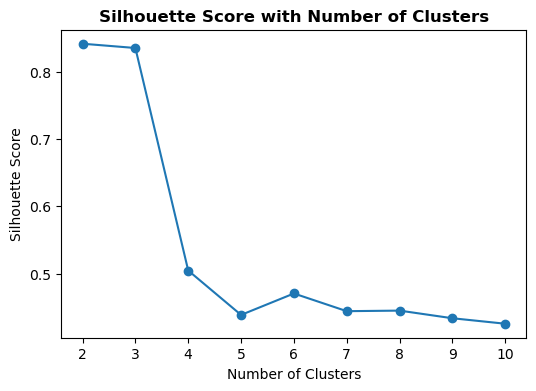

In [114]:
gdf_fua_rdi = gpd.read_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_fua_rdi.gpkg')

# Set up scaler
scaler = StandardScaler()

# Standardize relevant data
gdf_fua_rdi_selection = gdf_fua_rdi.copy()
gdf_fua_rdi_selection = gdf_fua_rdi_selection.dropna(axis=0).reset_index(drop=True)
gdf_fua_rdi_selection = gdf_fua_rdi_selection[['pop2020', 'den2020',  'rdi']]
for i in gdf_fua_rdi_selection.columns:
    gdf_fua_rdi_selection[i] = scaler.fit_transform(gdf_fua_rdi_selection[i].values.reshape(-1,1))

# Find optimal number of clusters using silhouette score
n_cl_list = []
ss_list = []

# Try a range of number of clusters
for n in range(2, 11):
    cluster_curr = KMeans(n_clusters=n, n_init=50).fit_predict(gdf_fua_rdi_selection)
    # Compute SS
    n_cl_list.append(n)
    ss_list.append(metrics.silhouette_score(gdf_fua_rdi_selection, cluster_curr))

# Plot silhouette score
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(n_cl_list, ss_list, marker='o');
ax.set(xlabel='Number of Clusters', ylabel = 'Silhouette Score');
ax.set_title('Silhouette Score with Number of Clusters',
             fontsize=12, weight='bold', ha='center');
#fig.savefig('outputs/figures/clustering/ss.png',
#            bbox_inches="tight")

ss_test = pd.DataFrame(zip(n_cl_list, ss_list), columns=['n_cluster', 'ss'])
ss_test

     pop2020   den2020       rdi
0  -0.009312  0.004185 -0.823356
1   0.529324  8.105129 -1.162138
2  11.047095  0.572929 -1.135941
3  -0.154657 -0.230816  0.836737


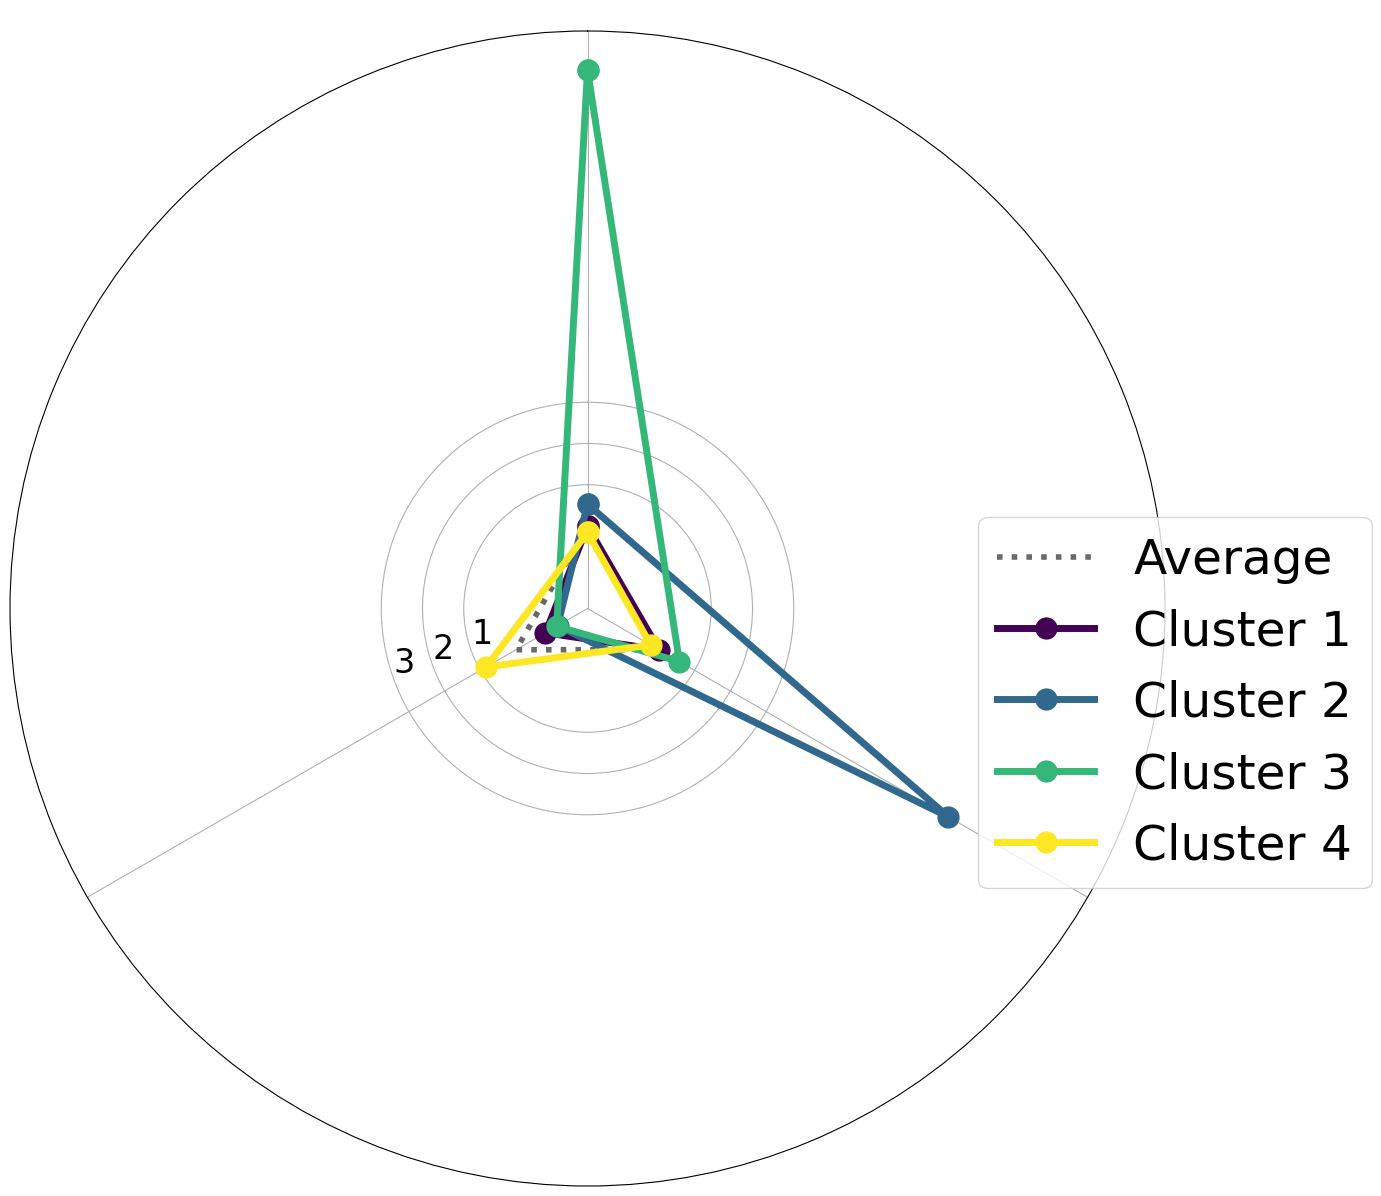

In [115]:
# Perform clustering
n_cl = 4

km_cluster = KMeans(n_clusters=n_cl, n_init=500).fit(gdf_fua_rdi_selection)
cluster_label = km_cluster.labels_

# Create df of stations and reassigned cluster label
cluster_df =\
    pd.DataFrame(zip(gdf_fua_rdi_selection.index, cluster_label),
                 columns=[gdf_fua_rdi_selection.index.name, 'Cluster'])


gdf_fua_rdi_c = gdf_fua_rdi.copy()
gdf_fua_rdi_c['Cluster'] = cluster_df['Cluster']

gdf_fua_rdi_c.to_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_fua_rdi_c.gpkg')

# Get cluster centroid
cluster_centroid = pd.DataFrame(km_cluster.cluster_centers_,
                                columns=gdf_fua_rdi_selection.columns)

print(cluster_centroid)
cluster_centroid.to_csv(wd + '/data/outputs/' + country + '/df_' + country + '_fua_cluster_centroids.csv')

# cluster_centroid.index = cluster_centroid.index.map(cluster_label)
avg_centroid = gdf_fua_rdi_selection.mean()



# Radar plot
cl_radar = plots.plot_radar_centroid(cl_centroid=cluster_centroid,
                          average_centroid=avg_centroid)
cl_radar.savefig(wd + '/plots/country_' + country + '/' + country + '_fua_radar_cluster.pdf', bbox_inches="tight")


# Average journey profile

# cl_demand = plots.plot_avg_demand_profile(df_throughput=df_stn_ts.set_index('StationName').drop('Daily throughput', axis=1),
#                                             df_entry=df_stn_ts_entry.set_index('StationName'),
#                                             df_exit=df_stn_ts_exit.set_index('StationName'),
#                                             cl_lab=cluster_df,
#                                             colors=colors,
#                                             time_map = time_map)
# cl_demand.savefig(f"outputs/figures/average_demand_profile_clusters.pdf", bbox_inches="tight")

### Admin areas

,n_cluster,ss
0,2,0.690916
1,3,0.537310
2,4,0.564119
3,5,0.511656
4,6,0.513281
5,7,0.474924
6,8,0.479646
7,9,0.475779
8,10,0.420744


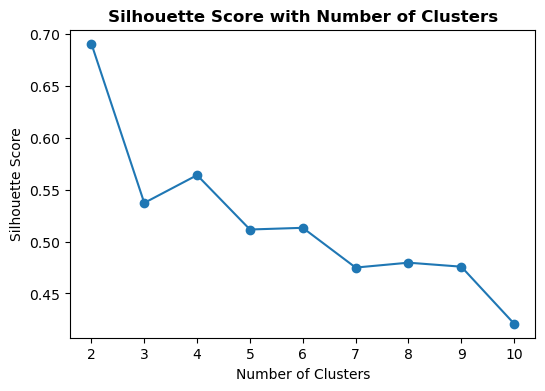

In [116]:
gdf_admin_fua_rdi = gpd.read_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_admin_fua_rdi.gpkg')

# Set up scaler
scaler = StandardScaler()


# Standardize relevant data
gdf_admin_fua_rdi_selection = gdf_admin_fua_rdi.copy()
gdf_admin_fua_rdi_selection = gdf_admin_fua_rdi_selection.dropna(axis=0).reset_index(drop=True)
gdf_admin_fua_rdi_selection = gdf_admin_fua_rdi_selection[['pop2020_FUA', 'den2020',  'rdi']]
for i in gdf_admin_fua_rdi_selection.columns:
    gdf_admin_fua_rdi_selection[i] = scaler.fit_transform(gdf_admin_fua_rdi_selection[i].values.reshape(-1,1))

# Find optimal number of clusters using silhouette score
n_cl_list = []
ss_list = []

# Try a range of number of clusters
for n in range(2, 11):
    cluster_curr = KMeans(n_clusters=n, n_init=50).fit_predict(gdf_admin_fua_rdi_selection)
    # Compute SS
    n_cl_list.append(n)
    ss_list.append(metrics.silhouette_score(gdf_admin_fua_rdi_selection, cluster_curr))

# Plot silhouette score
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(n_cl_list, ss_list, marker='o');
ax.set(xlabel='Number of Clusters', ylabel = 'Silhouette Score');
ax.set_title('Silhouette Score with Number of Clusters',
             fontsize=12, weight='bold', ha='center');
#fig.savefig('outputs/figures/clustering/ss.png',
#            bbox_inches="tight")

ss_test = pd.DataFrame(zip(n_cl_list, ss_list), columns=['n_cluster', 'ss'])
ss_test

   pop2020_FUA   den2020       rdi
0    -0.386227 -0.348416  0.608918
1     2.908918  0.366312 -0.904812
2     2.412335  4.790964 -2.472095
3    -0.193093  0.188957 -0.947539


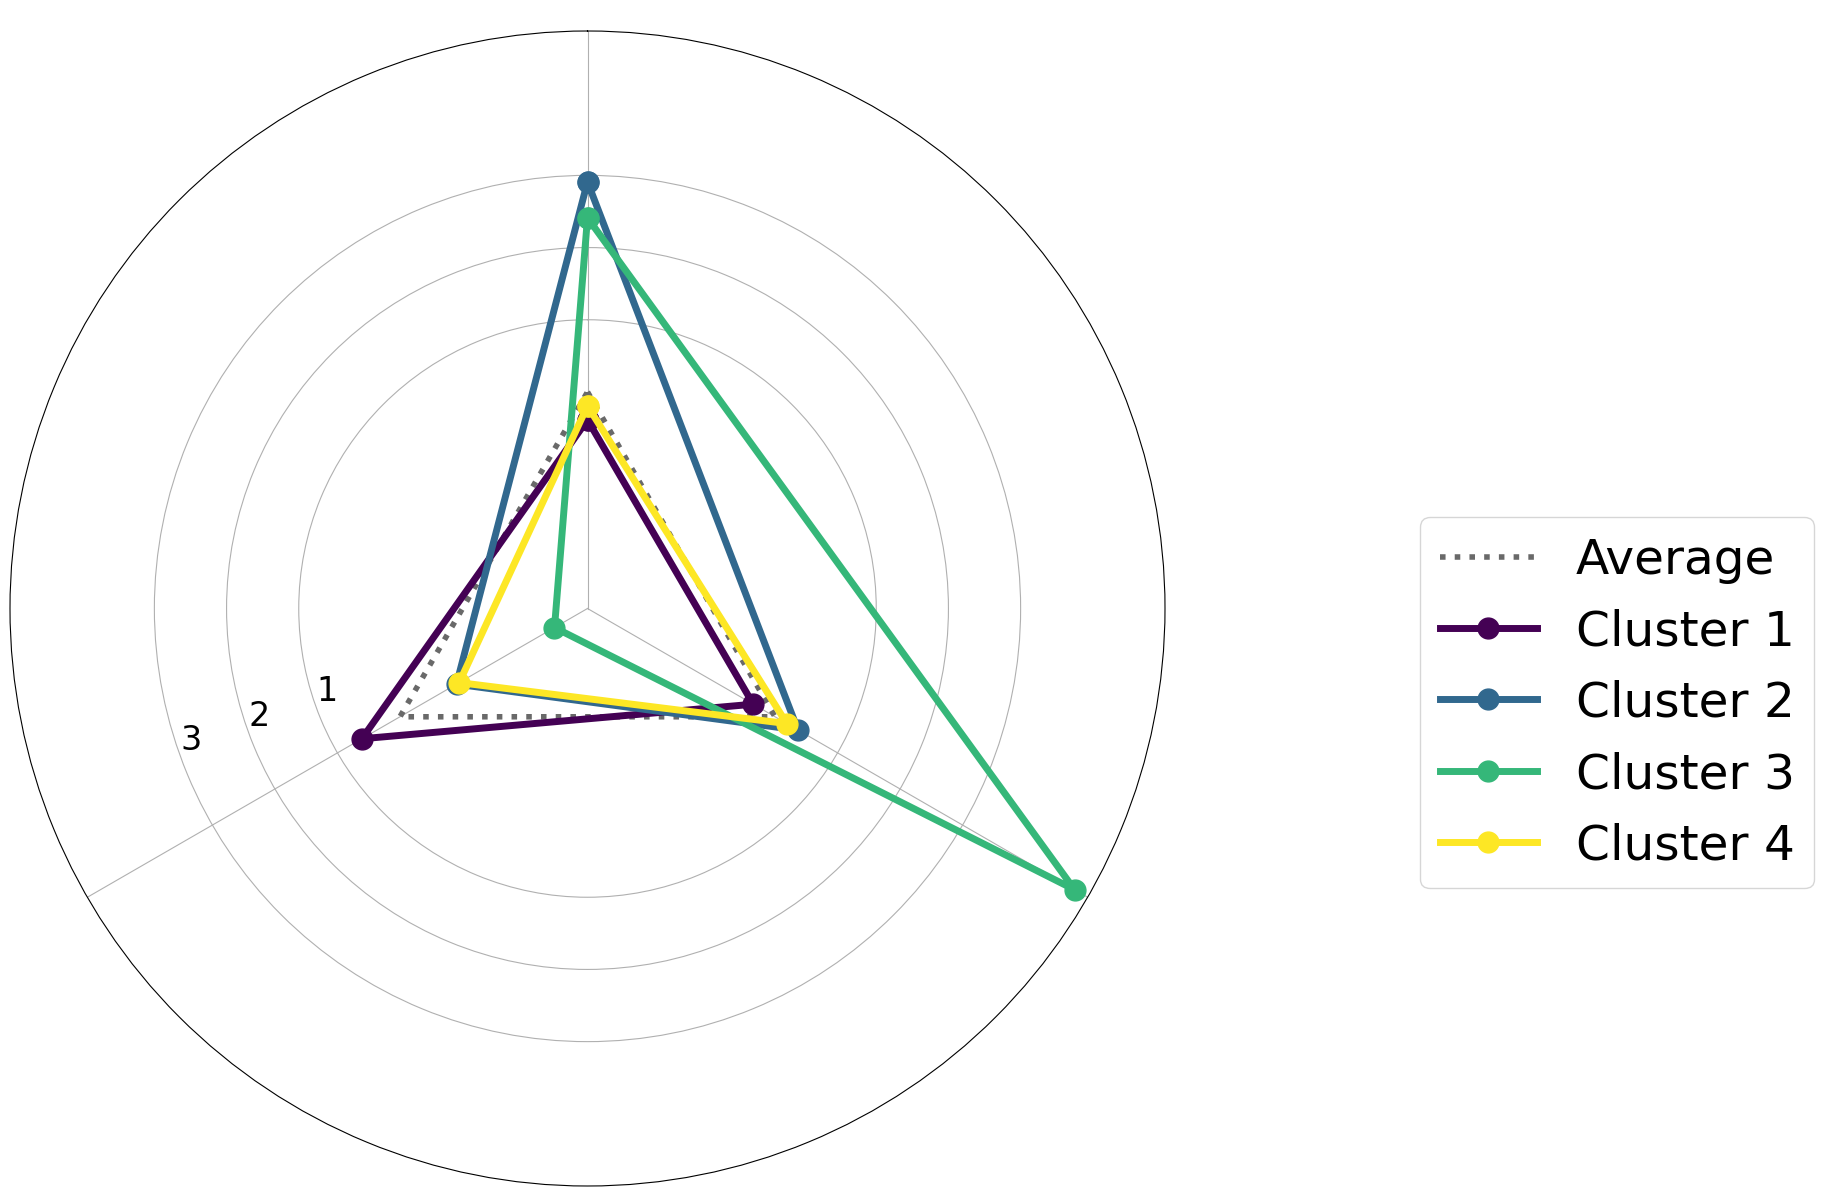

In [117]:
# Perform clustering
n_cl = 4

km_cluster = KMeans(n_clusters=n_cl, n_init=500).fit(gdf_admin_fua_rdi_selection)
cluster_label = km_cluster.labels_

# Create df of stations and reassigned cluster label
cluster_df =\
    pd.DataFrame(zip(gdf_admin_fua_rdi_selection.index, cluster_label),
                 columns=[gdf_admin_fua_rdi_selection.index.name, 'Cluster'])


gdf_admin_fua_rdi_c = gdf_admin_fua_rdi.copy()
gdf_admin_fua_rdi_c['Cluster'] = cluster_df['Cluster']

gdf_admin_fua_rdi_c.to_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_admin_fua_rdi_c.gpkg')

# Get cluster centroid
cluster_centroid = pd.DataFrame(km_cluster.cluster_centers_,
                                columns=gdf_admin_fua_rdi_selection.columns)

print(cluster_centroid)
cluster_centroid.to_csv(wd + '/data/outputs/' + country + '/df_' + country + '_admin_fua_cluster_centroids.csv')


# cluster_centroid.index = cluster_centroid.index.map(cluster_label)
avg_centroid = gdf_admin_fua_rdi_selection.mean()


# Set color cycle and palette
colors = mcp.gen_color(cmap='viridis', n=n_cl)


# Radar plot
cl_radar = plots.plot_radar_centroid(cl_centroid=cluster_centroid,
                          average_centroid=avg_centroid)
cl_radar.savefig(wd + '/plots/country_' + country + '/' + country + '_admin_fua_radar_cluster.pdf', bbox_inches="tight")



# Average journey profile

# cl_demand = plots.plot_avg_demand_profile(df_throughput=df_stn_ts.set_index('StationName').drop('Daily throughput', axis=1),
#                                             df_entry=df_stn_ts_entry.set_index('StationName'),
#                                             df_exit=df_stn_ts_exit.set_index('StationName'),
#                                             cl_lab=cluster_df,
#                                             colors=colors,
#                                             time_map = time_map)
# cl_demand.savefig(f"outputs/figures/average_demand_profile_clusters.pdf", bbox_inches="tight")

# Movement data join

In [118]:
df_mov = pyreadr.read_r('/Volumes/RECAST/data/outputs/' + country_full + '/movements/2022_03_mov.rds')
df_mov = df_mov[None]
df_mov = df_mov[df_mov['length_km'] > 0].reset_index(drop=True)
df_mov = df_mov[df_mov['length_km'] < 70].reset_index(drop=True)

df_mov['geometry'] = df_mov['geometry'].apply(shapely.wkt.loads)
gdf_mov = gpd.GeoDataFrame(df_mov, crs='epsg:4326')


### FUAs

In [119]:
gdf_fua_rdi_c = gpd.read_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_fua_rdi_c.gpkg')

gdf_fua_rdi_c_join = gdf_fua_rdi_c.to_crs('epsg:4326')

gdf_mov_join = gdf_mov
gdf_fua_rdi_c_mov = gdf_fua_rdi_c_join.sjoin(gdf_mov_join, how="left", predicate='intersects')

gdf_fua_rdi_c_mov['index'] = gdf_fua_rdi_c_mov.index

gdf_group = gdf_fua_rdi_c_mov.groupby(['index']).sum().reset_index(drop=True)

gdf_fua_rdi_c_join['n_crisis'] = gdf_group['n_crisis']
gdf_fua_rdi_c_join['n_baseline'] = gdf_group['n_baseline']
gdf_fua_rdi_c_join['perchange'] = (gdf_fua_rdi_c_join['n_crisis']-gdf_fua_rdi_c_join['n_baseline'])/gdf_fua_rdi_c_join['n_baseline']*100
gdf_fua_rdi_c_mov = gdf_fua_rdi_c_join

gdf_fua_rdi_c_mov.to_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_fua_rdi_c_mov.gpkg')



/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_6263/1928716106.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gdf_group = gdf_fua_rdi_c_mov.groupby(['index']).sum().reset_index(drop=True)


In [120]:
gdf_fua_rdi_c_mov = gpd.read_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_fua_rdi_c_mov.gpkg')

gdf_fua_rdi_c_mov_dropna = gdf_fua_rdi_c_mov.dropna(subset=['perchange']).reset_index(drop=True)
gdf_fua_rdi_c_mov_dropna['z'] = np.abs(scipy.stats.zscore(gdf_fua_rdi_c_mov_dropna['perchange']))
gdf_fua_rdi_c_mov_dropoutliers = gdf_fua_rdi_c_mov_dropna[gdf_fua_rdi_c_mov_dropna['z']<2.5].reset_index(drop=True)

gdf_fua_rdi_c_mov_dropoutliers = gdf_fua_rdi_c_mov_dropoutliers.sort_values(by='rdi')

X = sm.add_constant(gdf_fua_rdi_c_mov_dropoutliers['rdi'])

normal_model = sm.GLM(gdf_fua_rdi_c_mov_dropoutliers['perchange'], X, family=sm.families.Gaussian())
normal_results = normal_model.fit()

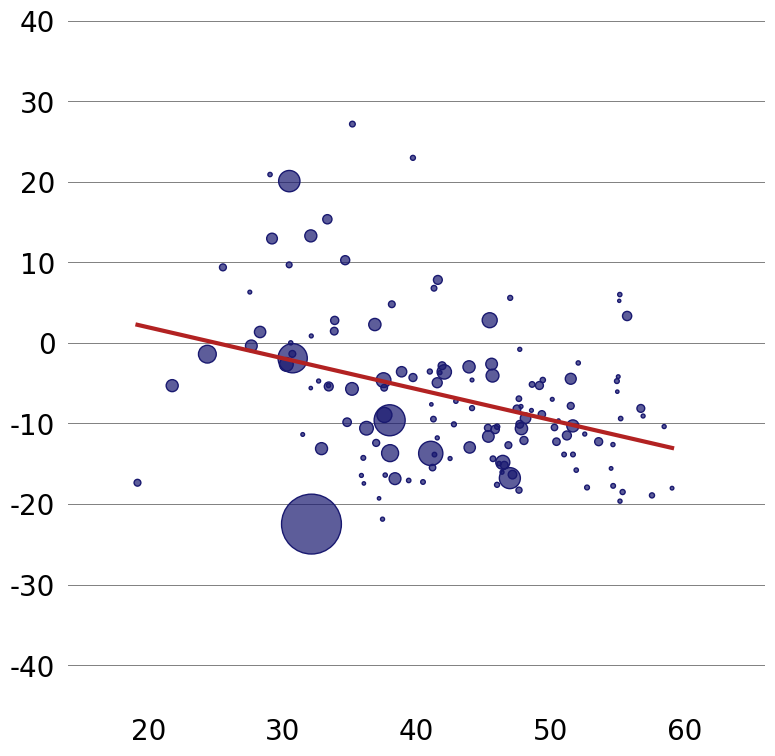

In [121]:
fig, ax = plt.subplots(figsize=(9,9))

ax.spines['bottom'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

radii=gdf_fua_rdi_c_mov_dropoutliers['pop2020']/12000

ax.scatter(gdf_fua_rdi_c_mov_dropoutliers['rdi'], gdf_fua_rdi_c_mov_dropoutliers['perchange'], color=(0.098,0.098,0.439,0.7), edgecolor = (0.098,0.098,0.439,1), s=radii, zorder=1)
ax.plot(gdf_fua_rdi_c_mov_dropoutliers['rdi'], normal_results.params[0] + normal_results.params[1]*gdf_fua_rdi_c_mov_dropoutliers['rdi'], color='firebrick', lw=3, zorder=2)

xmin, xmax = 14,66
ax.set_xlim([xmin, xmax])

ymin, ymax = -45,41
ax.set_ylim([ymin, ymax])

yticks = []
for i in range(int(ymin), int(ymax)):
    if i%10 == 0:
        yticks.append(i)
ax.set_yticks(yticks, yticks)
for y in yticks:
    ax.plot([xmin, xmax],[y,y], color='gray', lw=0.7, zorder=0)

# ax.set_xscale('log')
# ax.set_yscale('log')

# ax.text(0.5, -.1, 'Relative Deprivation Index', transform=ax.transAxes, va='center', ha='center', rotation=0, color='k', size = 15, zorder=11) 
# ax.text(-0.1, 0.5, '% change in mobility', transform=ax.transAxes, va='center', ha='center', rotation=90, color='k', size = 15, zorder=11) 

plt.savefig(wd + '/plots/country_' + country + '/' + country + '_preliminary_perchange_vs_rdi_fua.pdf', bbox_inches = 'tight')

plt.show()

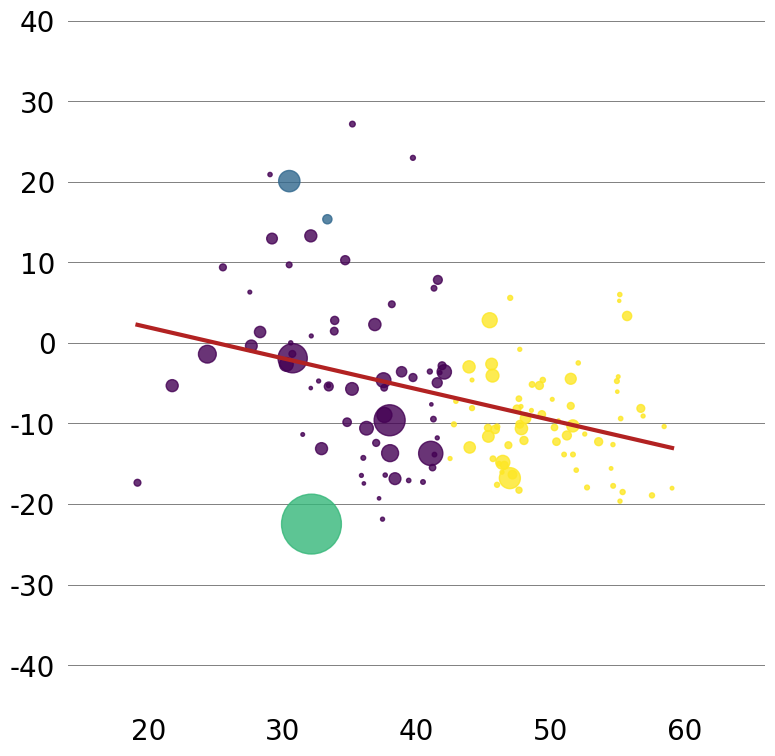

In [122]:
fig, ax = plt.subplots(figsize=(9,9))

ax.spines['bottom'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

radii=gdf_fua_rdi_c_mov_dropoutliers['pop2020']/12000

ax.scatter(gdf_fua_rdi_c_mov_dropoutliers['rdi'], gdf_fua_rdi_c_mov_dropoutliers['perchange'], c=gdf_fua_rdi_c_mov_dropoutliers['Cluster'], cmap='viridis', alpha=0.8, s=radii, zorder=1)
ax.plot(gdf_fua_rdi_c_mov_dropoutliers['rdi'], normal_results.params[0] + normal_results.params[1]*gdf_fua_rdi_c_mov_dropoutliers['rdi'], color='firebrick', lw=3, zorder=2)

xmin, xmax = 14,66
ax.set_xlim([xmin, xmax])

ymin, ymax = -45,41
ax.set_ylim([ymin, ymax])

yticks = []
for i in range(int(ymin), int(ymax)):
    if i%10 == 0:
        yticks.append(i)
ax.set_yticks(yticks, yticks)
for y in yticks:
    ax.plot([xmin, xmax],[y,y], color='gray', lw=0.7, zorder=0)

# ax.set_xscale('log')
# ax.set_yscale('log')

# ax.text(0.5, -.1, 'Relative Deprivation Index', transform=ax.transAxes, va='center', ha='center', rotation=0, color='k', size = 15, zorder=11) 
# ax.text(-0.1, 0.5, '% change in mobility', transform=ax.transAxes, va='center', ha='center', rotation=90, color='k', size = 15, zorder=11) 

plt.savefig(wd + '/plots/country_' + country + '/' + country + '_preliminary_perchange_vs_rdi_fua_c.pdf', bbox_inches = 'tight')

plt.show()

/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_6263/1212476632.py:25: RuntimeWarning: invalid value encountered in double_scalars
  random_pos = [np.random.uniform(cl-width/2+width/2*abs(x-np.median(cluster_data['perchange']))/max_dev,
/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_6263/1212476632.py:26: RuntimeWarning: invalid value encountered in double_scalars
  cl+width/2-width/2*abs(x-np.median(cluster_data['perchange']))/max_dev, (1,1))[0][0]


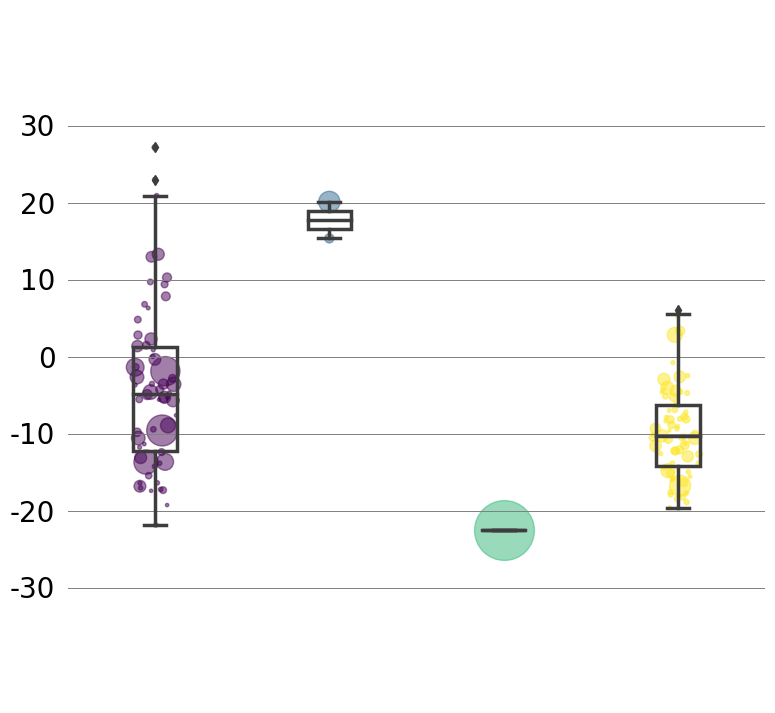

In [123]:
fig,ax = plt.subplots(figsize=(9,9))

ax.spines['bottom'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9, labelbottom=False)

plot_data = gdf_fua_rdi_c_mov_dropoutliers

sns.boxplot(data=plot_data, x='Cluster', y='perchange',
                    width=0.25, linewidth=2.5, boxprops={"facecolor": 'None'}, ax=ax, zorder=1)

s = plot_data['pop2020']/12000
plot_data['size'] = s

for cl in range(int(max(plot_data['Cluster'])+1)):
    cluster_data = plot_data[plot_data['Cluster']==cl].reset_index(drop=True)

    width = 0.3
    
    try:
        max_dev = max([abs(x-np.median(cluster_data['perchange'])) for x in cluster_data['perchange']])
        random_pos = [np.random.uniform(cl-width/2+width/2*abs(x-np.median(cluster_data['perchange']))/max_dev, 
                      cl+width/2-width/2*abs(x-np.median(cluster_data['perchange']))/max_dev, (1,1))[0][0] 
                      for x in cluster_data['perchange']]

        ax.scatter(random_pos, cluster_data['perchange'],
               facecolor = colors[cl], alpha=0.5, s = cluster_data['size'], zorder=0)
    
    except:
        ax.scatter([cl],[cluster_data['perchange']], facecolor = colors[cl], alpha=0.5, s=cluster_data['size'], zorder=0)

ymin, ymax = -35, 35
ax.set_ylim([ymin-10, ymax+10])

xmin, xmax = 0-.5, int(max(plot_data['Cluster']))+.5

yticks = []
for i in range(int(ymin), int(ymax)):
    if i%10 == 0:
        yticks.append(i)
ax.set_yticks(yticks, yticks)
for y in yticks:
    ax.plot([xmin, xmax],[y,y], color='gray', lw=0.7, zorder=0)
    
ax.set(xlabel=None)
ax.set(ylabel=None)

plt.savefig(wd + '/plots/country_' + country + '/' + country + '_fua_boxplot_cluster.pdf', bbox_inches = 'tight')

plt.show()

In [124]:
gdf_admin_fua_rdi_c = gpd.read_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_admin_fua_rdi_c.gpkg')
 
gdf_admin_fua_rdi_c_join = gdf_admin_fua_rdi_c.to_crs('epsg:4326')

gdf_mov_join = gdf_mov
gdf_admin_fua_rdi_c_mov = gdf_admin_fua_rdi_c_join.sjoin(gdf_mov_join, how="left", predicate='intersects')

gdf_admin_fua_rdi_c_mov['index'] = gdf_admin_fua_rdi_c_mov.index

gdf_group = gdf_admin_fua_rdi_c_mov.groupby(['index']).sum().reset_index(drop=True)

gdf_admin_fua_rdi_c_join['n_crisis'] = gdf_group['n_crisis']
gdf_admin_fua_rdi_c_join['n_baseline'] = gdf_group['n_baseline']
gdf_admin_fua_rdi_c_join['perchange'] = (gdf_admin_fua_rdi_c_join['n_crisis']-gdf_admin_fua_rdi_c_join['n_baseline'])/gdf_admin_fua_rdi_c_join['n_baseline']*100
gdf_admin_fua_rdi_c_mov = gdf_admin_fua_rdi_c_join

gdf_admin_fua_rdi_c_mov.to_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_admin_fua_rdi_c_mov.gpkg')


/var/folders/79/65l52xsj7vq_4_t_l6k5bl2c0000gn/T/ipykernel_6263/4145396840.py:10: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  gdf_group = gdf_admin_fua_rdi_c_mov.groupby(['index']).sum().reset_index(drop=True)


In [125]:
gdf_admin_fua_rdi_c_mov = gpd.read_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_admin_fua_rdi_c_mov.gpkg')

gdf_admin_fua_rdi_c_mov_dropna = gdf_admin_fua_rdi_c_mov.dropna(subset=['perchange']).reset_index(drop=True)
gdf_admin_fua_rdi_c_mov_dropna['z'] = np.abs(scipy.stats.zscore(gdf_admin_fua_rdi_c_mov_dropna['perchange']))
gdf_admin_fua_rdi_c_mov_dropoutliers = gdf_admin_fua_rdi_c_mov_dropna[gdf_admin_fua_rdi_c_mov_dropna['z']<2].reset_index(drop=True)


gdf_admin_fua_rdi_c_mov_dropoutliers = gdf_admin_fua_rdi_c_mov_dropoutliers.sort_values(by='rdi')

X = sm.add_constant(gdf_admin_fua_rdi_c_mov_dropoutliers['rdi'])

normal_model_admin = sm.GLM(gdf_admin_fua_rdi_c_mov_dropoutliers['perchange'], X, family=sm.families.Gaussian())
normal_results_admin = normal_model_admin.fit()

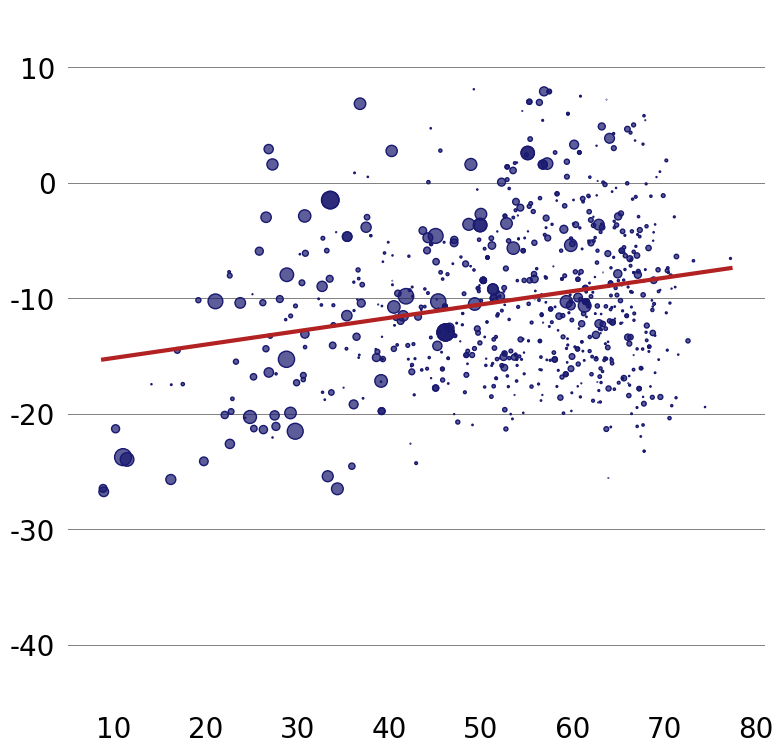

In [126]:
fig,ax = plt.subplots(figsize=(9,9))

ax.spines['bottom'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

radii=gdf_admin_fua_rdi_c_mov_dropoutliers['pop2020']/12000

ax.scatter(gdf_admin_fua_rdi_c_mov_dropoutliers['rdi'], gdf_admin_fua_rdi_c_mov_dropoutliers['perchange'], color=(0.098,0.098,0.439,0.7), edgecolor=(0.098,0.098,0.439,1), s=radii, zorder=1)
ax.plot(gdf_admin_fua_rdi_c_mov_dropoutliers['rdi'], normal_results_admin.params[0] + normal_results_admin.params[1]*gdf_admin_fua_rdi_c_mov_dropoutliers['rdi'], color='firebrick', lw=3, zorder=2)

xmin, xmax = 5,81
ax.set_xlim([xmin, xmax])

ymin, ymax = -45,15
ax.set_ylim([ymin, ymax])

yticks = []
for i in range(int(ymin), int(ymax)):
    if i%10 == 0:
        yticks.append(i)
ax.set_yticks(yticks, yticks)
for y in yticks:
    ax.plot([xmin, xmax],[y,y], color='gray', lw=0.7, zorder=0)

# ax.set_xscale('log')
# ax.set_yscale('log')

# ax.text(0.5, -.1, 'Relative Deprivation Index', transform=ax.transAxes, va='center', ha='center', rotation=0, color='k', size = 15, zorder=11) 
# ax.text(-0.1, 0.5, '% change in mobility', transform=ax.transAxes, va='center', ha='center', rotation=90, color='k', size = 15, zorder=11) 

plt.savefig(wd + '/plots/country_' + country + '/' + country + '_preliminary_perchange_vs_rdi_admin_fua.pdf', bbox_inches = 'tight')

plt.show()

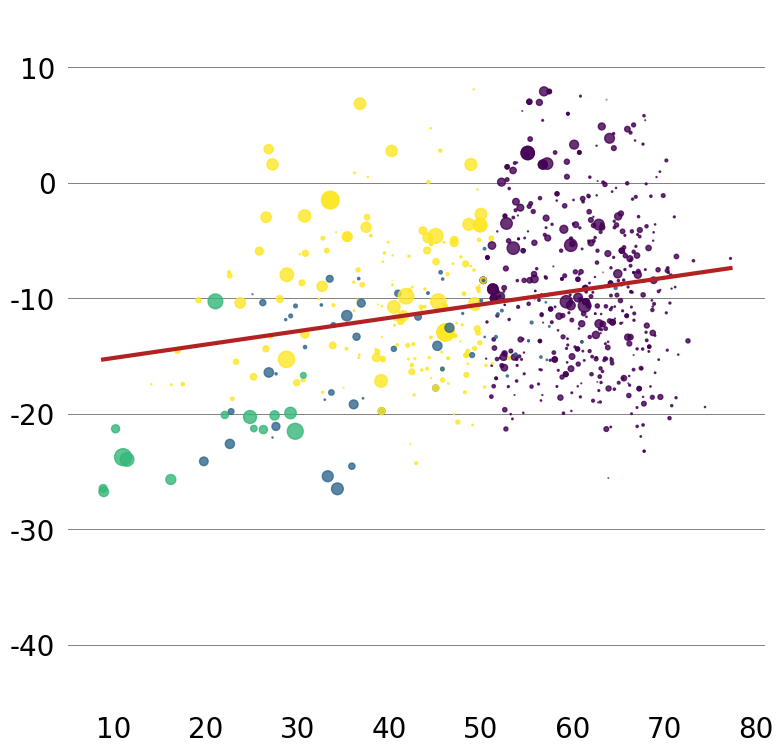

In [127]:
fig,ax = plt.subplots(figsize=(9,9))

ax.spines['bottom'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9)

radii=gdf_admin_fua_rdi_c_mov_dropoutliers['pop2020']/12000

ax.scatter(gdf_admin_fua_rdi_c_mov_dropoutliers['rdi'], gdf_admin_fua_rdi_c_mov_dropoutliers['perchange'], c=gdf_admin_fua_rdi_c_mov_dropoutliers['Cluster'], cmap='viridis', alpha=0.8, s=radii, zorder=1)
ax.plot(gdf_admin_fua_rdi_c_mov_dropoutliers['rdi'], normal_results_admin.params[0] + normal_results_admin.params[1]*gdf_admin_fua_rdi_c_mov_dropoutliers['rdi'], color='firebrick', lw=3, zorder=2)

xmin, xmax = 5,81
ax.set_xlim([xmin, xmax])

ymin, ymax = -45,15
ax.set_ylim([ymin, ymax])

yticks = []
for i in range(int(ymin), int(ymax)):
    if i%10 == 0:
        yticks.append(i)
ax.set_yticks(yticks, yticks)
for y in yticks:
    ax.plot([xmin, xmax],[y,y], color='gray', lw=0.7, zorder=0)

# ax.set_xscale('log')
# ax.set_yscale('log')

# ax.text(0.5, -.1, 'Relative Deprivation Index', transform=ax.transAxes, va='center', ha='center', rotation=0, color='k', size = 15, zorder=11) 
# ax.text(-0.1, 0.5, '% change in mobility', transform=ax.transAxes, va='center', ha='center', rotation=90, color='k', size = 15, zorder=11) 

plt.savefig(wd + '/plots/country_' + country + '/' + country + '_preliminary_perchange_vs_rdi_admin_fua_c.pdf', bbox_inches = 'tight')

plt.show()

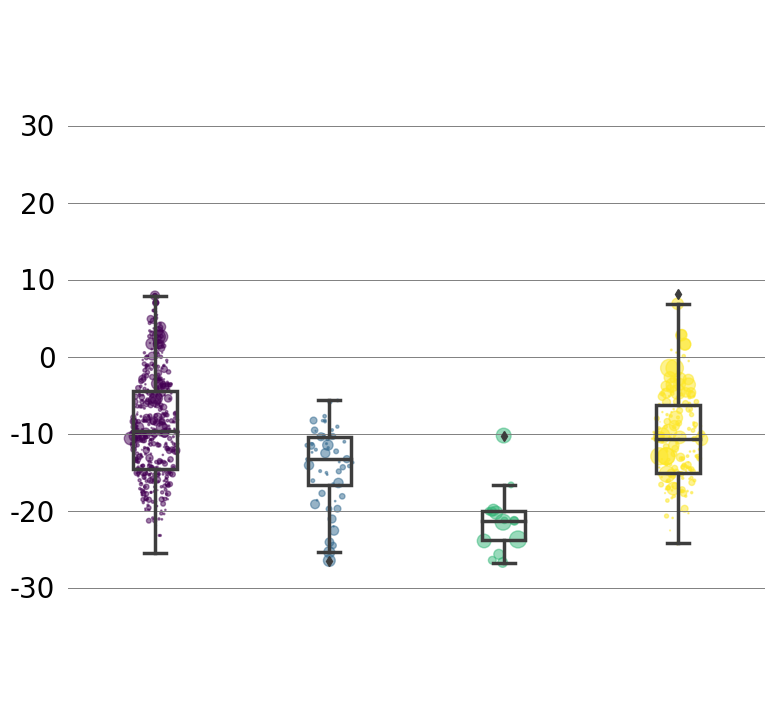

In [128]:
fig,ax = plt.subplots(figsize=(9,9))

ax.spines['bottom'].set_linewidth(0)
ax.spines['top'].set_linewidth(0)
ax.spines['left'].set_linewidth(0)
ax.spines['right'].set_linewidth(0)

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelsize=20, pad=9, labelbottom=False)

plot_data = gdf_admin_fua_rdi_c_mov_dropoutliers

sns.boxplot(data=plot_data, x='Cluster', y='perchange',
                    width=0.25, linewidth=2.5, boxprops={"facecolor": 'None'}, ax=ax, zorder=1)

s = plot_data['pop2020']/12000
plot_data['size'] = s

for cl in range(int(max(plot_data['Cluster'])+1)):
    cluster_data = plot_data[plot_data['Cluster']==cl].reset_index(drop=True)

    width = 0.3
    max_dev = max([abs(x-np.median(cluster_data['perchange'])) for x in cluster_data['perchange']])
    
    try:
        random_pos = [np.random.uniform(cl-width/2+width/2*abs(x-np.median(cluster_data['perchange']))/max_dev, 
                      cl+width/2-width/2*abs(x-np.median(cluster_data['perchange']))/max_dev, (1,1))[0][0] 
                      for x in cluster_data['perchange']]

        ax.scatter(random_pos, cluster_data['perchange'],
               facecolor = colors[cl], alpha=0.5, s = cluster_data['size'], zorder=0)
    
    except:
        ax.scatter([cl],[cluster_data['perchange']], facecolor = colors[cl], alpha=0.5, s=cluster_data['size'], zorder=0)

ymin, ymax = -35, 35
ax.set_ylim([ymin-10, ymax+10])

xmin, xmax = 0-.5, int(max(plot_data['Cluster']))+.5

yticks = []
for i in range(int(ymin), int(ymax)):
    if i%10 == 0:
        yticks.append(i)
ax.set_yticks(yticks, yticks)
for y in yticks:
    ax.plot([xmin, xmax],[y,y], color='gray', lw=0.7, zorder=0)
    
ax.set(xlabel=None)
ax.set(ylabel=None)

plt.savefig(wd + '/plots/country_' + country + '/' + country + '_admin_fua_boxplot_cluster.pdf', bbox_inches = 'tight')

plt.show()

# Maps

In [ ]:
gdf_fua_rdi = gpd.read_file(wd + '/data/outputs/' + country + '/gdf_' + country + '_fua_rdi.gpkg').to_crs('EPSG:3857')

In [ ]:
fig,ax = plt.subplots(figsize=(10,10))

gdf_countries = gpd.read_file(wd + '/data/inputs/boundaries/CNTR_BN_01M_2020_3857.shp')


ax.spines['bottom'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)

ax.tick_params(axis = 'both', which = 'both', width = 0, length = 0, color = 'k', labelleft=False, labelbottom=False)

gdf_fua_rdi.plot(column='rdi', ax= ax, legend=False, edgecolor=(0,0,0,0.7), lw=0.4)

bbox = gdf_fua_rdi.total_bounds

ax.set_xlim([bbox[0] - (bbox[2]-bbox[0])*0.9, bbox[2] + (bbox[2]-bbox[0])*0.7])
ax.set_ylim([bbox[1] - (bbox[3]-bbox[1])*0.2, bbox[3] + (bbox[3]-bbox[1])*0.1])

# gdf_fua_rdi_img, gdf_fua_rdi_ext = cx.bounds2img(bbox[0], bbox[1], bbox[2], bbox[3], zoom=3)
# ax.imshow(gdf_fua_rdi_img, extent = gdf_fua_rdi_ext, alpha=0.6)

gdf_countries.plot(ax=ax)

cbaxes = fig.add_axes([0.7, .7, 0.15, 0.015]) 
plt.scatter([0,0.25,0.5,0.76,1], [0,0.25,0.5,0.75,1], s=0, c=[0,0.25,0.5,0.75,1], cmap='viridis', alpha=0.99)
cbar = plt.colorbar(cax=cbaxes, ticks=[0,1], orientation='horizontal')
cbaxes.tick_params(axis = 'x', which = 'both', width = 0, length = 0, color = 'k', labelsize = 10, pad=3, 
                   top=True, bottom=False, labeltop=True, labelbottom=False)
cbaxes.tick_params(axis = 'y', which = 'both', width = 0, length = 0, color = 'k', labelsize = 10, pad=3)
# cbaxes.set_xticklabels([int(min(stringencies)), int(max(stringencies))])
cbaxes.set_xticklabels([int(round(min(gdf_fua_rdi['rdi']),0)),int(round(max(gdf_fua_rdi['rdi']),0))])
cbaxes.text(0.5, -0.6, 'Relative Deprivation', transform=cbaxes.transAxes, va='top', ha='center', rotation=0, color='k', size = 11, zorder=11)
cbar.outline.set_linewidth(0.5)

# plt.savefig(wd + '/plots/country_' + country + '/' + country + '_preliminary_map_FUA_rdi.pdf', bbox_inches = 'tight')

plt.show()